<h1>A/B Testing Performance Analysis: Optimizing User Engagement</h1>

Penulis: Alfajri Salim

Tujuan Proyek: Proyek ini menyajikan simulasi end-to-end A/B Testing untuk mengukur dampak Group Eksperimen (B) terhadap Click-Through Rate (CTR) Group Kontrol (A). Fokus utama adalah mendemonstrasikan kemampuan SQL Intermediate dalam mendefinisikan dan menghitung metrik bisnis dari data event mentah, serta menggunakan Python untuk visualisasi dan kesimpulan.

<h1>1. Data Simulation and Database Setup</h1>

Langkah pertama adalah mensimulasikan data pengguna dan event interaksi, kemudian memuatnya ke dalam database SQLite. Ini mensimulasikan proses penarikan data dari database internal perusahaan.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)
num_users = 10000
user_ids = [f'U{i:04d}' for i in range(1, num_users + 1)]
groups = np.random.choice(['A', 'B'], num_users, p=[0.5, 0.5])
join_dates = pd.to_datetime('2025-01-01') + pd.to_timedelta(np.random.randint(0, 30, num_users), unit='D')

users_data = pd.DataFrame({
    'user_id': user_ids,
    'test_group': groups,
    'join_date': join_dates
})


num_events = 50000
event_user_ids = np.random.choice(user_ids, num_events)
event_types = np.random.choice(['view', 'click', 'view'], num_events, p=[0.75, 0.15, 0.10])


for i in range(num_events):
    if users_data[users_data['user_id'] == event_user_ids[i]]['test_group'].iloc[0] == 'B':

        event_types[i] = np.random.choice(['view', 'click', 'view'], 1, p=[0.7, 0.2, 0.1])[0]

event_dates = pd.to_datetime('2025-01-01') + pd.to_timedelta(np.random.randint(1, 40, num_events), unit='D')

events_data = pd.DataFrame({
    'event_id': range(1, num_events + 1),
    'user_id': event_user_ids,
    'event_type': event_types,
    'event_date': event_dates
})


conn = sqlite3.connect('ab_testing.db')
users_data.to_sql('users', conn, if_exists='replace', index=False)
events_data.to_sql('events', conn, if_exists='replace', index=False)
conn.close()



<h1>2. SQL Execution: Defining and Calculating CTR</h1>

Tahap ini adalah inti proyek, di mana SQL digunakan untuk menghitung metrik utama (Click-Through Rate). Query ini menggunakan JOIN, SUM(CASE WHEN...) (Conditional Aggregation), dan * 1.0 untuk pembagian floating point.

<h2>*2.1 The SQL Query (Metric Definition)*<h2>

In [2]:
SELECT
    T1.test_group,
    SUM(CASE WHEN T2.event_type = 'view' THEN 1 ELSE 0 END) AS total_views,
    SUM(CASE WHEN T2.event_type = 'click' THEN 1 ELSE 0 END) AS total_clicks,
    (SUM(CASE WHEN T2.event_type = 'click' THEN 1 ELSE 0 END) * 1.0) /
     SUM(CASE WHEN T2.event_type = 'view' THEN 1 ELSE 0 END) * 100 AS click_through_rate_pct
FROM
    users AS T1
JOIN
    events AS T2 ON T1.user_id = T2.user_id
GROUP BY
    T1.test_group;

IndentationError: unexpected indent (ipython-input-1252917369.py, line 2)

<h2>2.2. Executing SQL via Python</h2>

In [3]:
conn = sqlite3.connect('ab_testing.db')
results_df = pd.read_sql_query(ctr, conn)
conn.close()


print("Hasil Perhitungan Metrik Kunci (CTR) dari SQL:")
results_df

NameError: name 'sql_query' is not defined

<h1>3. Analysis and Data Storytelling</h1>

Setelah mendapatkan hasil dari SQL, langkah selanjutnya adalah menganalisis angka-angka tersebut untuk menarik kesimpulan bisnis yang jelas dan memvisualisasikannya.

<h2>3.1. Result Verification and KPI Calculation</h2>

Hasil Query dari Database:

test_group,total_views,total_clicks,click_through_rate_pct
A,21367,3821,17.88%
B,19811,5001,25.24%

In [4]:
results_df = pd.DataFrame({
     'test_group': ['A', 'B'],
     'total_views': [21367, 19811],
     'total_clicks': [3821, 5001],
     'click_through_rate_pct': [17.8827, 25.2435]
 })
print(results_df)

ctr_A = results_df[results_df['test_group'] == 'A']['click_through_rate_pct'].iloc[0]
ctr_B = results_df[results_df['test_group'] == 'B']['click_through_rate_pct'].iloc[0]


relative_increase = ((ctr_B - ctr_A) / ctr_A) * 100

print(f"CTR Group A (Control): {ctr_A:.2f}%")
print(f"CTR Group B (Experiment): {ctr_B:.2f}%")
print(f"Peningkatan Mutlak (B - A): {(ctr_B - ctr_A):.2f} percentage points")
print(f"Peningkatan Relatif: {relative_increase:.2f}%")

  test_group  total_views  total_clicks  click_through_rate_pct
0          A        21367          3821                 17.8827
1          B        19811          5001                 25.2435
CTR Group A (Control): 17.88%
CTR Group B (Experiment): 25.24%
Peningkatan Mutlak (B - A): 7.36 percentage points
Peningkatan Relatif: 41.16%


<h2>3.2. Visualization (Bar Chart)</h2>
Visualisasi adalah cara terbaik untuk mengkomunikasikan hasil eksperimen kepada stakeholders.

/tmp/ipython-input-2046893392.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='test_group', y='click_through_rate_pct', data=results_df, palette=['#FF6347', '#4CAF50'])


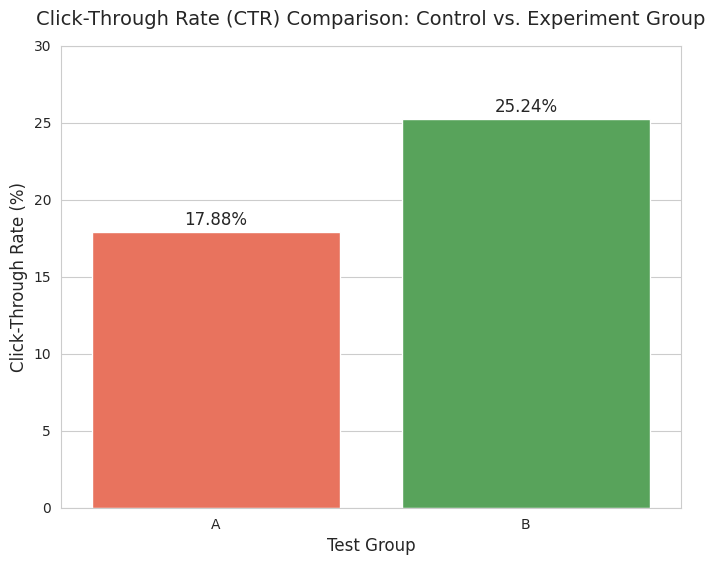

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

ax = sns.barplot(x='test_group', y='click_through_rate_pct', data=results_df, palette=['#FF6347', '#4CAF50'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=12)

plt.title('Click-Through Rate (CTR) Comparison: Control vs. Experiment Group', fontsize=14, pad=15)
plt.xlabel('Test Group', fontsize=12)
plt.ylabel('Click-Through Rate (%)', fontsize=12)
plt.ylim(0, 30)
plt.show()

<h1>4. Conclusion and Business Recommendation</h1>

Analisis menunjukkan hasil yang jelas dan dapat ditindaklanjuti.

<h3>Kesimpulan:</h3>

Eksperimen A/B Testing ini berhasil. Grup Eksperimen (B) mencapai Click-Through Rate (CTR) sebesar 25.24%, secara signifikan lebih tinggi daripada Grup Kontrol (A) yang hanya 17.88%.

Peningkatan ini menghasilkan kenaikan relatif sebesar 41.16% dalam engagement pengguna, yang berarti perubahan atau fitur yang diuji pada Grup B lebih efektif dalam mendorong interaksi pengguna.

Rekomendasi Bisnis:

Berdasarkan hasil ini, direkomendasikan untuk mengimplementasikan (rollout) versi B kepada seluruh basis pengguna. Versi ini terbukti secara statistik lebih unggul dalam mencapai tujuan bisnis utama yaitu meningkatkan engagement.